In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from glob import glob
import os
import TOC_functions
%matplotlib widget

In [4]:
root_folder = os.path.expanduser('C:/Users/ica/OneDrive - Plymouth Marine Laboratory/vscode/TOC_analysis/data/2025/02')  # yourpath
picarro_df = TOC_functions.merge_picarro_files(root_folder)
picarro_df = TOC_functions.qc(picarro_df)
picarro_df.set_index('datetime', inplace=True)



In [5]:
# filter by time

start_time = datetime.datetime(2025, 2, 14, 12, 30, 0)
end_time = datetime.datetime(2025, 2, 17, 11, 0, 0)
df = picarro_df.loc[start_time:end_time]

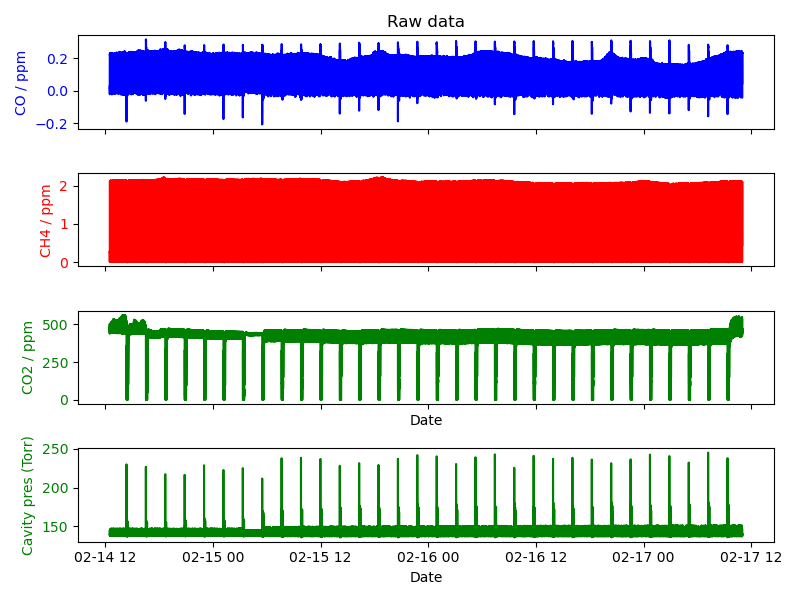

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(8, 6))
#fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(8, 5))

# Plot for CO
ax1.set_title('Raw data')

ax1.plot(df.index, df.CO, label='CO / ppm', color='blue')
ax1.set_ylabel('CO / ppm', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot for CH4
ax2.plot(df.index, df.CH4, label='CH4 / ppm', color='red')
ax2.set_ylabel('CH4 / ppm', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot for CO2
ax3.plot(df.index, df.CO2, label='CO2 / ppm', color='green')
ax3.set_xlabel('Date')
ax3.set_ylabel('CO2 / ppm', color='green')
ax3.tick_params(axis='y', labelcolor='green')

ax4.plot(df.index, df.CavityPressure, label='', color='green')
ax4.set_xlabel('Date')
ax4.set_ylabel('Cavity pres (Torr)', color='green')
ax4.tick_params(axis='y', labelcolor='green')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [7]:

def TOC_df(df):
    df_copy = df.copy()

    # Create new column for valve state
    df_copy.loc[:, 'valve_state'] = df_copy['solenoid_valves'].apply(lambda x: 
        'ambient' if x < 1.75 
        else 'ambient_catalyst' if 1.75 <= x < 3.5
        else 'blank_ambient' if 3.5 <= x < 4.5
        else 'blank_catalyst')
    
    # Create new column for blank
    df_copy.loc[:, 'is_blank'] = df_copy['solenoid_valves'] >= 3.5
    
    # Create new column for valve type
    df_copy.loc[:, 'valve_type'] = df_copy['valve_state'].apply(
        lambda x: 'catalyst' if 'catalyst' in x else 'ambient')
    #creates boolean where true is if valve changes and flase if it doesnt, 
    #valve changes only keeps the rows where the valve changes
    valve_changes = df_copy[df_copy['valve_type'] != df_copy['valve_type'].shift()]
    
    # Lists for storing averages
    avg_times = []
    avg_co2_ambient = []
    avg_co2_catalyst = []
    avg_ch4_ambient = []
    avg_ch4_catalyst = []
    avg_co_ambient = []
    avg_co_catalyst = []
    is_blank_list = []
    
  
    
    for i in valve_changes.index:
        end_time = i - pd.Timedelta(seconds=2)
        start_time = end_time - pd.Timedelta(seconds=20)
        
        window_df = df_copy[(df_copy.index > start_time) & (df_copy.index < end_time)]
        if window_df.empty:

            continue    
        # Calculate averages
        avg_co2 = window_df['CO2_corrected'].mean()
        avg_ch4 = window_df['CH4_corrected'].mean()
        avg_co = window_df['CO'].mean()
        avg_time_val = window_df.index.mean()
        is_blank = window_df['is_blank'].iloc[-1]
        valve_type = window_df['valve_type'].iloc[-1]
        
        # Store values
        avg_times.append(avg_time_val)
        is_blank_list.append(is_blank)
        
        if 'catalyst' in valve_type:
            avg_co2_catalyst.append(avg_co2)
            avg_ch4_catalyst.append(avg_ch4)
            avg_co_catalyst.append(avg_co)
            avg_co2_ambient.append(np.nan)
            avg_ch4_ambient.append(np.nan)
            avg_co_ambient.append(np.nan)
        else:
            avg_co2_ambient.append(avg_co2)
            avg_ch4_ambient.append(avg_ch4)
            avg_co_ambient.append(avg_co)
            avg_co2_catalyst.append(np.nan)
            avg_ch4_catalyst.append(np.nan)
            avg_co_catalyst.append(np.nan)
    
    return pd.DataFrame({
        'datetime': avg_times,
        'avg_co2_ambient': avg_co2_ambient,
        'avg_ch4_ambient': avg_ch4_ambient,
        'avg_co_ambient': avg_co_ambient,
        'avg_co2_catalyst': avg_co2_catalyst,
        'avg_ch4_catalyst': avg_ch4_catalyst,
        'avg_co_catalyst': avg_co_catalyst,
        'is_blank': is_blank_list
    }).set_index('datetime')





In [8]:
df_toc = TOC_df(df)

In [9]:
def plot_TOC(df_result):
    fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

    gases = [
        ("co2", "blue", axes[0]),
        ("ch4", "green", axes[1]),
        ("co", "red", axes[2])
    ]

    for gas, color, ax in gases:
        ax.plot(df_result.index, df_result[f'avg_{gas}_ambient'], 
                marker='o', linestyle='-', color=color, alpha=0.6, label=f'{gas.upper()} Ambient')
        ax.plot(df_result.index, df_result[f'avg_{gas}_catalyst'], 
                marker='s', linestyle='--', color=color, alpha=0.8, label=f'{gas.upper()} Catalyst')

        ax.set_ylabel(f"{gas.upper()} ppm", color=color)
        ax.legend()
        ax.grid()

    axes[-1].set_xlabel("Time")
    
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

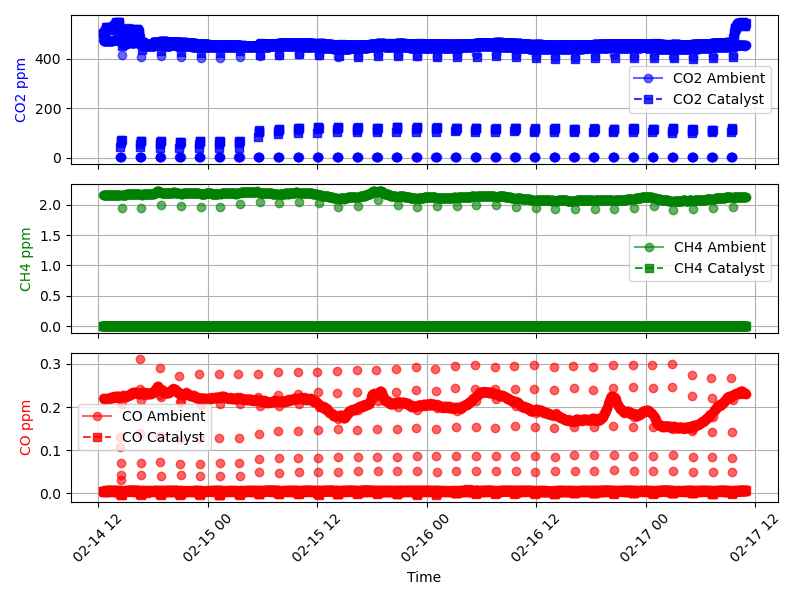

In [16]:
plot_TOC(df_toc)


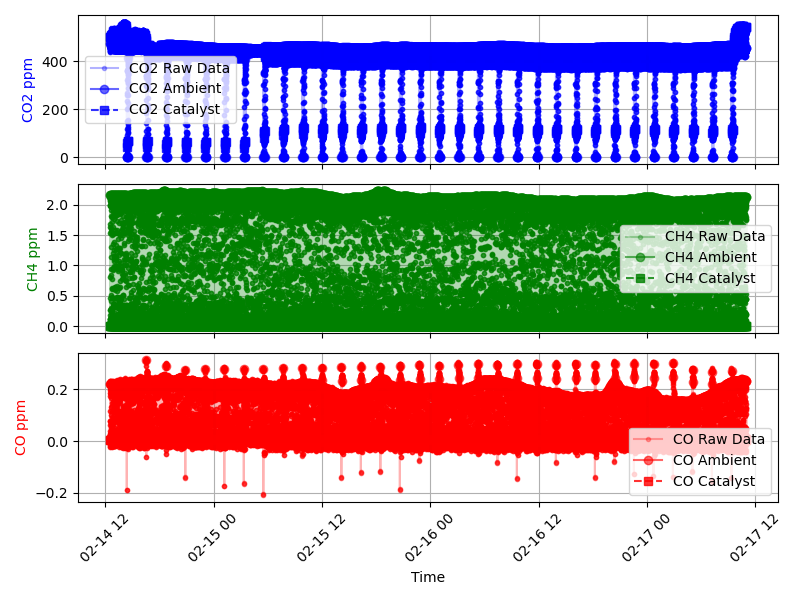

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# CO2 Plot
ax1.plot(df.index, df["CO2"], marker='.', linestyle='-', color='blue', alpha=0.3, label="CO2 Raw Data")
ax1.plot(df_toc.index, df_toc["avg_co2_ambient"], marker='o', linestyle='-', color='blue', alpha=0.6, label="CO2 Ambient")
ax1.plot(df_toc.index, df_toc["avg_co2_catalyst"], marker='s', linestyle='--', color='blue', alpha=0.8, label="CO2 Catalyst")
ax1.set_ylabel("CO2 ppm", color="blue")
ax1.legend()
ax1.grid()

# CH4 Plot
ax2.plot(df.index, df["CH4"], marker='.', linestyle='-', color='green', alpha=0.3, label="CH4 Raw Data")
ax2.plot(df_toc.index, df_toc["avg_ch4_ambient"], marker='o', linestyle='-', color='green', alpha=0.6, label="CH4 Ambient")
ax2.plot(df_toc.index, df_toc["avg_ch4_catalyst"], marker='s', linestyle='--', color='green', alpha=0.8, label="CH4 Catalyst")
ax2.set_ylabel("CH4 ppm", color="green")
ax2.legend()
ax2.grid()

# CO Plot
ax3.plot(df.index, df["CO"], marker='.', linestyle='-', color='red', alpha=0.3, label="CO Raw Data")
ax3.plot(df_toc.index, df_toc["avg_co_ambient"], marker='o', linestyle='-', color='red', alpha=0.6, label="CO Ambient")
ax3.plot(df_toc.index, df_toc["avg_co_catalyst"], marker='s', linestyle='--', color='red', alpha=0.8, label="CO Catalyst")
ax3.set_ylabel("CO ppm", color="red")
ax3.set_xlabel("Time")
ax3.legend()
ax3.grid()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
'''
CHANGES: 
Delete first two datapoints of the blank and first TOC value after the blank
'''


def calculate_toc(TOC_df):
    """Calculate TOC values, including blank measurements as flagged rows"""
    toc_results = []
    
    # Drop last row if odd number of rows
    if len(TOC_df) % 2 != 0:
        TOC_df = TOC_df.iloc[:-1]  # Make even

    for i in range(0, len(TOC_df) - 1, 2):
        pair = TOC_df.iloc[i:i+2]
        
        mean_time = pair.index.mean()
        is_blank = pair['is_blank'].any()
        
        # Check if both measurements are blanks or both are ambient
        if (pair['is_blank'] == pair['is_blank'].iloc[0]).all():
            sum_catalyst = pair[['avg_co2_catalyst', 'avg_ch4_catalyst', 'avg_co_catalyst']].sum().sum()
            sum_ambient = pair[['avg_co2_ambient', 'avg_ch4_ambient', 'avg_co_ambient']].sum().sum()
            toc = sum_catalyst - sum_ambient
        else:
            toc = np.nan
            
        toc_results.append({
            'datetime': mean_time,
            'TOC': toc,
            'is_blank': is_blank
        })
    
    df_result = pd.DataFrame(toc_results).set_index('datetime')

    # Identify consecutive `True` sequences in `is_blank`
    mask = df_result['is_blank']
    groups = (mask != mask.shift()).cumsum()  # Group consecutive Trues/Falses
    group_counts = mask.groupby(groups).transform('sum')  # Count size of each group

    # Identify first and last rows in sequences where count > 3
    start_mask = (group_counts > 3) & (~mask.shift(1, fill_value=False))  # First True in the sequence
    end_mask = (group_counts > 3) & (~mask.shift(-1, fill_value=False))  # Last True in the sequence

    # Set TOC values in those positions to NaN
    df_result.loc[start_mask, 'TOC'] = np.nan
    df_result.loc[end_mask, 'TOC'] = np.nan

    return df_result

In [19]:
toc = calculate_toc(df_toc)

In [20]:
toc_results = toc[toc['is_blank'] == False]
toc_blank = toc[toc['is_blank'] == True]
##toc_blank_filtered= toc_blank[toc_blank['TOC'] <= 0.15]
#toc_results_filtered= toc_results[toc_results['TOC'] <= 600]

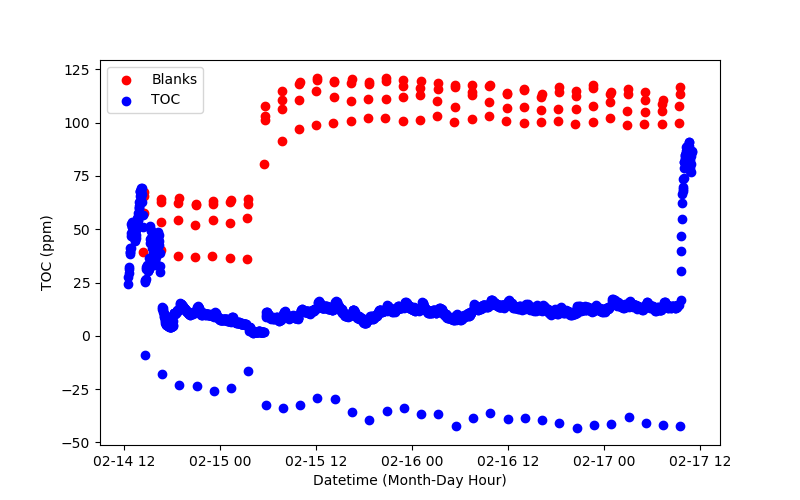

In [15]:
plt.close('all')
plt.figure(figsize=(8, 5))
#plt.scatter(toc_blank_filtered.index, toc_blank_filtered['TOC'], label='Blanks', color = 'red')
#plt.scatter(toc_results_filtered.index, toc_results_filtered['TOC'], label='TOC', color='blue')
plt.scatter(toc_blank.index, toc_blank['TOC'], label='Blanks', color = 'red')
plt.scatter(toc_results.index, toc_results['TOC'], label='TOC', color='blue')



# Labels and legend
plt.xlabel('Datetime (Month-Day Hour)')
plt.ylabel('TOC (ppm)')
plt.legend()

# Show plot
plt.show()


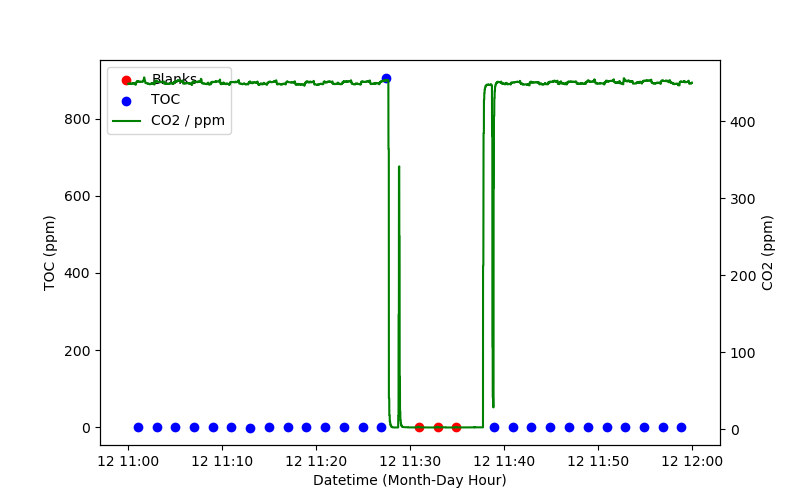

In [234]:

fig, ax1 = plt.subplots(figsize=(8, 5))

# Scatter plots for TOC data on the primary y-axis (left)
ax1.scatter(toc_blank_filtered.index, toc_blank_filtered['TOC'], label='Blanks', color='red')
ax1.scatter(toc_results_filtered.index, toc_results_filtered['TOC'], label='TOC', color='blue')

ax1.set_xlabel('Datetime (Month-Day Hour)')
ax1.set_ylabel('TOC (ppm)', color='black')

# Create a secondary y-axis for gas concentrations
ax2 = ax1.twinx()
ax2.plot(df.index, df.CO2_corrected, label='CO2 / ppm', color='green')


ax2.set_ylabel('CO2 (ppm)', color='black')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


In [282]:
toc_blank['TOC'].mean()

0.09024452570226611